In [1]:
import torch
from transformers import AutoTokenizer, AutoModel, BertConfig
from tqdm.auto import tqdm, trange
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
import torch.nn as nn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/opt/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
config = BertConfig.from_pretrained("zhihan1996/DNABERT-2-117M")
tokenizer = AutoTokenizer.from_pretrained("zhihan1996/DNABERT-2-117M", trust_remote_code=True)
model = AutoModel.from_config(config)

In [4]:
import os

In [6]:
os.listdir('lossers/data')

['sequence.txt', 'sequence-wide.tsv', '.ipynb_checkpoints']

In [26]:
df = pd.read_csv('lossers/data/sequence-wide.tsv', sep='\t')
df.head()

,genus,species,sequence,identifier,is_complete
0,Alitibacter,langaaensis,ATTGAAGAGTTTGATCATGGCTCAGATTGAACGCTGGCGGCAGGCT...,NR_118751.1,partial sequence
1,Alitibacter,langaaensis,ATTGAACGCTGGCGGCAGGCTTAACACATGCAAGTCGAACGGTAAC...,NR_042885.1,partial sequence
2,Roseovarius,maritimus,CAACTTGAGAGTTTGATCCTGGCTCAGAACGAACGCTGGCGGCAGG...,NR_200035.1,complete sequence
3,Roseovarius,roseus,CAACTTGAGAGTTTGATCCTGGCTCAGAACGAACGCTGGCGGCAGG...,NR_200034.1,complete sequence
4,Planosporangium,spinosum,TTGTTGGAGAGTTTGATCCTGGCTCAGGACGAACGCTGGCGGCGTG...,NR_200033.1,complete sequence


In [27]:
df['full_name'] = df['genus'] + '_' + df['species']
# df['label'] = df['full_name'].astype('category').cat.codes
num_labels = df['full_name'].nunique()
print(f'Number of unique labels: {num_labels}')

Number of unique labels: 20797


In [29]:
df['length'] = df['sequence'].str.len()
df = df[df['is_complete'].isin(['partial sequence', 'complete sequence'])]

# keep only full_name values that appear at least twice
counts = df['full_name'].value_counts()
valid_full_names = counts[counts >= 2].index
df = df[df['full_name'].isin(valid_full_names)].reset_index(drop=True)

print(f"Rows after filtering: {len(df)}")
print(f"Unique full_name after filtering: {df['full_name'].nunique()}")
# sanity check: every remaining full_name appears at least twice
assert df['full_name'].value_counts().min() >= 2

df = df[(df['length'] > 1300) & (df['length'] < 1600)].reset_index(drop=True)

Rows after filtering: 11135
Unique full_name after filtering: 4203


In [30]:
df['genus_label'] = df['genus'].astype('category').cat.codes
num_genus_labels = df['genus_label'].nunique()
print(f'Number of unique genus labels: {num_genus_labels}')
df.head()

Number of unique genus labels: 1349


,genus,species,sequence,identifier,is_complete,full_name,length,genus_label
0,Alitibacter,langaaensis,ATTGAAGAGTTTGATCATGGCTCAGATTGAACGCTGGCGGCAGGCT...,NR_118751.1,partial sequence,Alitibacter_langaaensis,1477,68
1,Alitibacter,langaaensis,ATTGAACGCTGGCGGCAGGCTTAACACATGCAAGTCGAACGGTAAC...,NR_042885.1,partial sequence,Alitibacter_langaaensis,1363,68
2,Arcobacter,iocasae,ATGCAAGTCGAACGAGAACGGATTATAGCTTGCTATAATTGTCAGC...,NR_200026.1,partial sequence,Arcobacter_iocasae,1381,127
3,Kitasatospora,hibisci,TTCACGGAGAGTTTGATCCTGGCTCAGGACGAACGCTGGCGGCGTG...,NR_200017.1,complete sequence,Kitasatospora_hibisci,1517,582
4,Dellaglioa,kimchii,TTTTTTGTTTTTTTCCTCTGTCAGGATGAACGCTGGCGGCGTGCCT...,NR_200012.1,partial sequence,Dellaglioa_kimchii,1513,299


In [31]:
df['species_label'] = df['species'].astype('category').cat.codes
num_species_labels = df['species_label'].nunique()
print(f'Number of unique species labels: {num_species_labels}')

Number of unique species labels: 3271


In [5]:
dna = df.iloc[0]['sequence']
inputs = tokenizer(dna, return_tensors = 'pt')["input_ids"]
hidden_states = model(inputs)[0] # [1, sequence_length, 768]

# embedding with mean pooling
embedding_mean = torch.mean(hidden_states[0], dim=0)
print(embedding_mean.shape) # expect to be 768

# embedding with max pooling
embedding_max = torch.max(hidden_states[0], dim=0)[0]
print(embedding_max.shape) # expect to be 768


torch.Size([768])
torch.Size([768])


/tmp/ipykernel_36308/771255905.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=counts.index.astype(str), y=counts.values, palette='pastel')


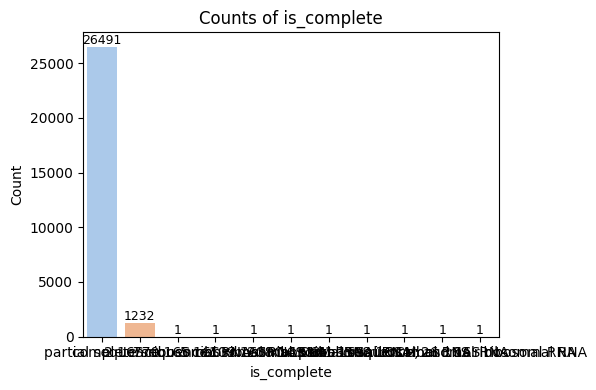

In [6]:
# Bar plot for 'is_complete' values in df
if 'is_complete' not in df.columns:
    raise KeyError("Column 'is_complete' not found in df")

counts = df['is_complete'].value_counts(dropna=False)

plt.figure(figsize=(6,4))
ax = sns.barplot(x=counts.index.astype(str), y=counts.values, palette='pastel')
ax.set_xlabel('is_complete')
ax.set_ylabel('Count')
ax.set_title('Counts of is_complete')

# annotate bars with counts
for p, v in zip(ax.patches, counts.values):
    ax.annotate(f"{int(v)}", (p.get_x() + p.get_width() / 2, v), ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

In [8]:
df['is_complete'].value_counts()

is_complete
partial sequence                           26491
complete sequence                           1232
2 16S ribosomal RNA                            1
770 16S ribosomal RNA                          1
5 16S ribosomal RNA                            1
109 16S ribosomal RNA                          1
208 16S ribosomal RNA                          1
IFO 15161 16S ribosomal RNA                    1
DSM 3508 16S ribosomal RNA                     1
partial sequence; and 16S ribosomal RNA        1
OCM 26 16S ribosomal RNA                       1
Name: count, dtype: int64